In [36]:
# Definitions and functions

%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
from basic_viewing import h5_functions as h5
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml


# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'analysis-tools'))

#setup the data folder
ss_data_folder = os.path.join(experiment_folder, 'ss_data')

import soundtools as st
import Kwik as oe
from file_tools import experiment as et

#file structure
bird = 'z020'
sess = '2016-06-02_11-10-42_2100'
ss_sess_path = os.path.join(ss_data_folder, bird, sess_name)

# open the file in read moe
kwik_files = glob.glob(os.path.join(ss_sess_path, '*.kwik'))

# get the motif wav file
motif_files = glob.glob(os.path.join(ss_sess_path, 'motif*.wav'))

Computer: lintu.ucsd.edu


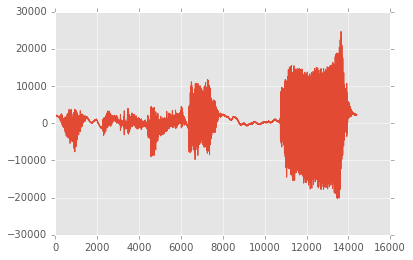

In [41]:
[sound_sf, motif] = sio.wavfile.read(motif_files[0])
plt.plot(motif)

In [ ]:
#file structure
bird = 'z020'
sess = '2016-06-02_11-10-42_2100'
ss_sess_path = os.path.join(ss_data_folder, bird, sess_name)

In [6]:
kwik_files.sort()
kwik_files

['/mnt/cube/earneodo/bci_zf/ss_data/z020/2016-06-02_11-10-42_2100/experiment1.kwik',
 '/mnt/cube/earneodo/bci_zf/ss_data/z020/2016-06-02_11-10-42_2100/experiment1_0.kwik',
 '/mnt/cube/earneodo/bci_zf/ss_data/z020/2016-06-02_11-10-42_2100/experiment1_1.kwik',
 '/mnt/cube/earneodo/bci_zf/ss_data/z020/2016-06-02_11-10-42_2100/experiment1_2.kwik']

In [7]:
# get one shank:
shank = 0
kwik_file_path = kwik_files[shank]
kwik_file = h5py.File(kwik_file_path, 'r')   
kwik_file.keys()

[u'application_data', u'channel_groups', u'recordings']

In [9]:
# a brutal stimulus: just the time_stamps of the beginnings of the bout (by hand, for now)
s_f = 30000

bout_starts_s = [3674.214226,
                 5440.417182,
                 5440.931701,
                 5441.436431,
                 5441.937063,
                 5442.929469,
                 5444.768863,
                 3677.666521]

bout_starts_auto = np.array([110240580, 110267024, 110344054, 163226653, 163241769, 163256932,
       163272248, 163302176, 163357081])
                 
inc_bout_starts_s = [5441.402442,
                   5443.408628,
                   5443.814313,
                   5425.276764,
                   5445.283357,
                   3674.734087,
                   3675.104892,
                   3675.615050,
                   3676.133218,
                   3676.509485,
                   3676.984166,
                   3678.181699]


all_starts_samples = np.array(bout_starts_s + inc_bout_starts_s)*s_f
all_starts_samples = all_starts_samples.astype(np.int)
#all_starts_samples = bout_starts_auto

In [10]:
# functions to browse through the stims and units
from phy_tools import kwik_functions as kwf

shank = 1
kwik_file_path = kwik_files[shank]
kwik_file = h5py.File(kwik_file_path, 'r')  

s_f = kwf.get_record_sampling_frequency(kwik_file)
# list all the sorted units
all_units = kwf.list_units(kwik_file, sorted=False)
# this returns a numpy recarray with cols:
# group: site group (electrode shank)
# clu: cluster number
# qlt: sorting quality: 1 is MUA, 2 is well isolated (by default, only these 2 qlt's are returned)
# For instance, see all the clusters that are either mua or good units.
print all_units['clu']

[ 0 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30 31
 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47  5  6  7  8  9]


[ 0 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30 31
 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52 53 54
 55 56 57 58 59  6 60  7  8  9]


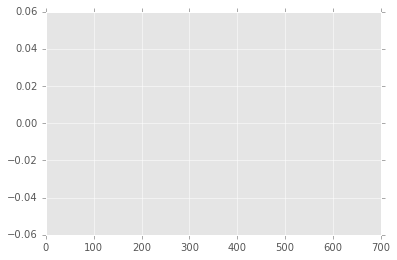

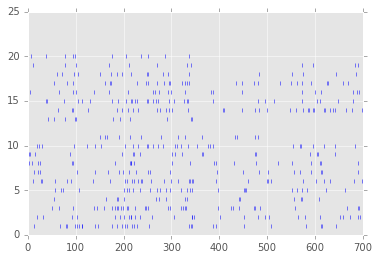

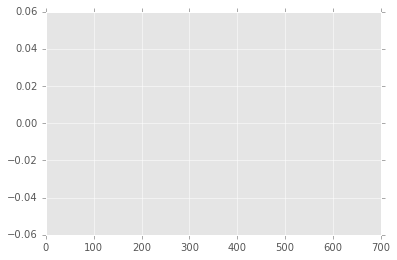

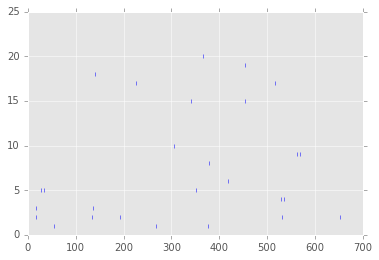

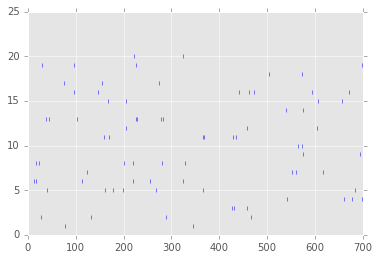

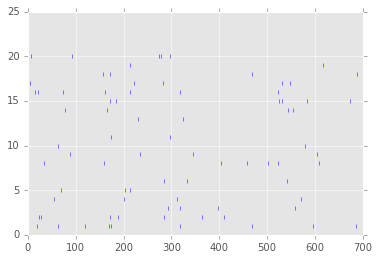

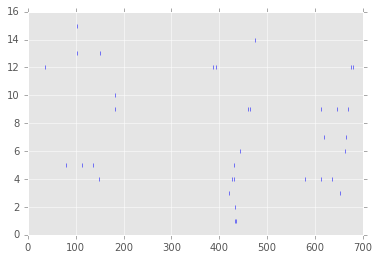

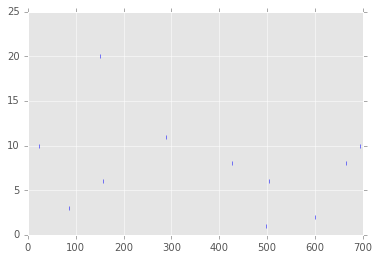

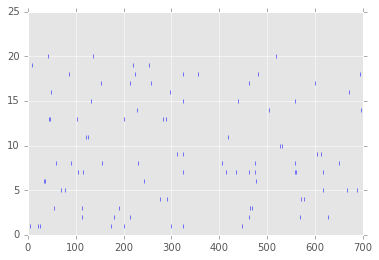

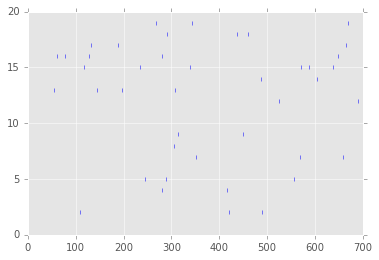

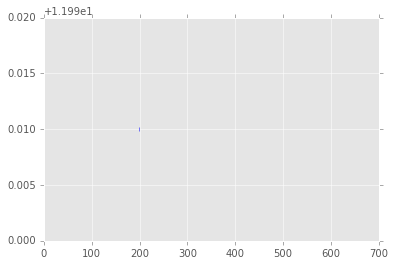

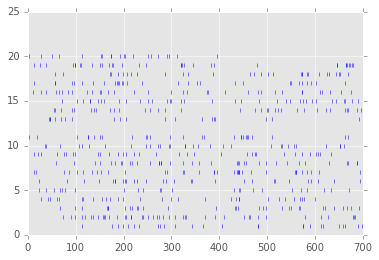

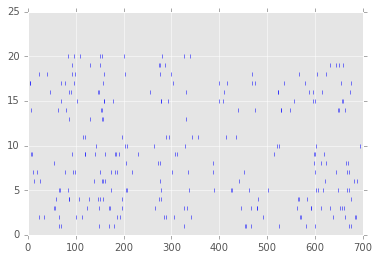

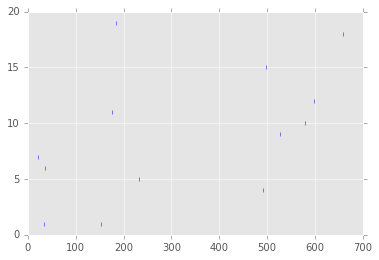

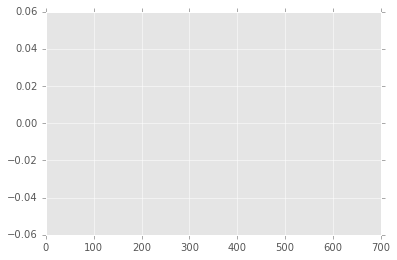

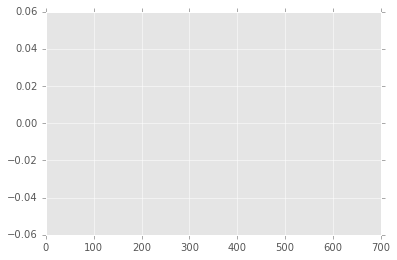

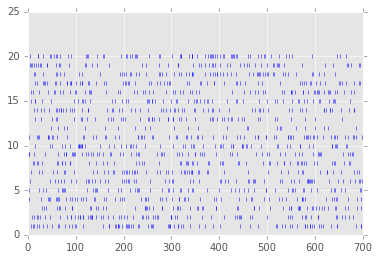

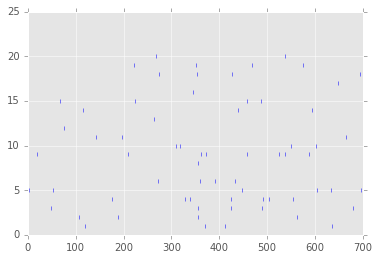

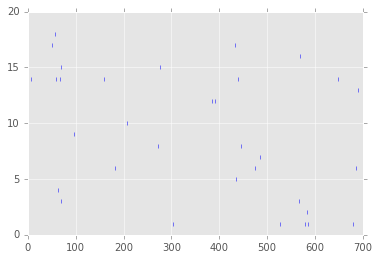

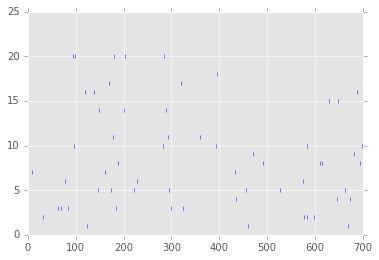

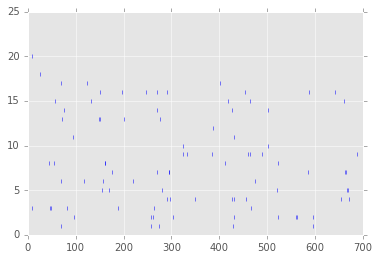

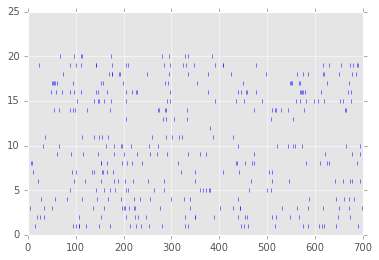

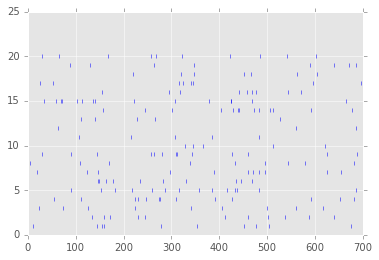

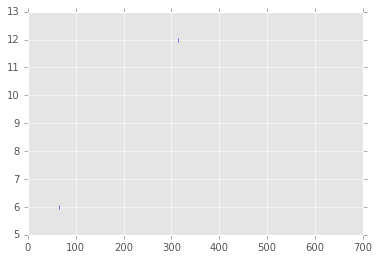

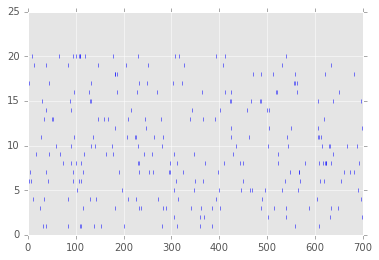

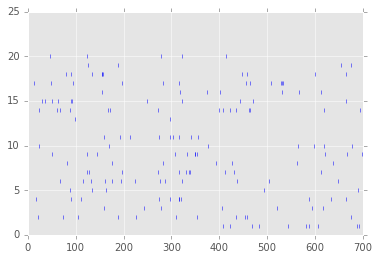

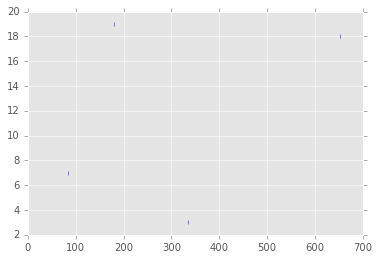

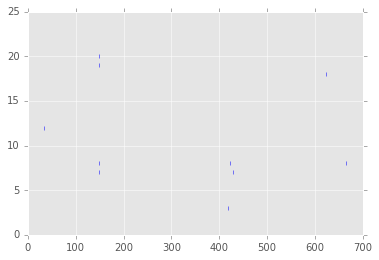

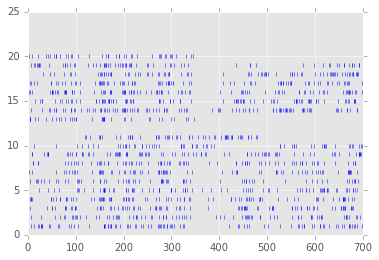

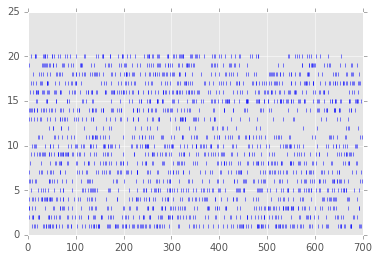

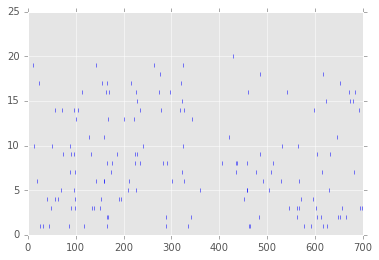

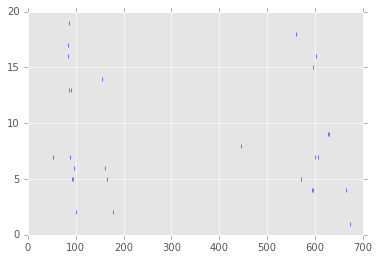

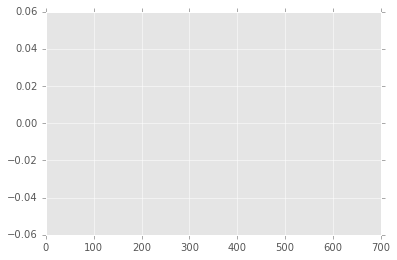

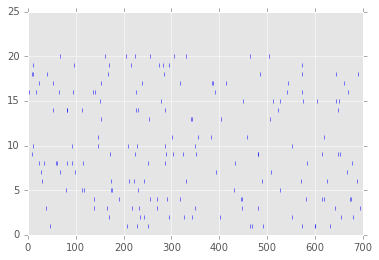

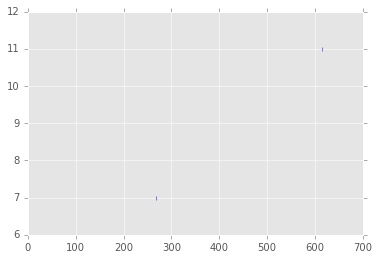

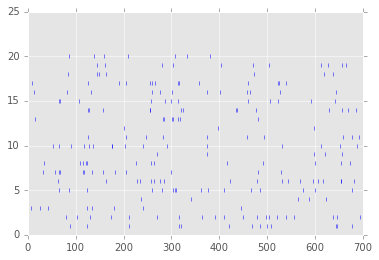

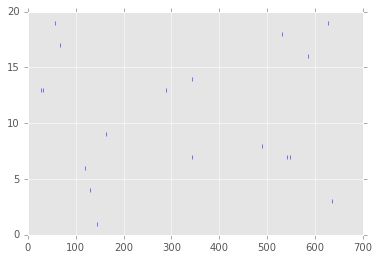

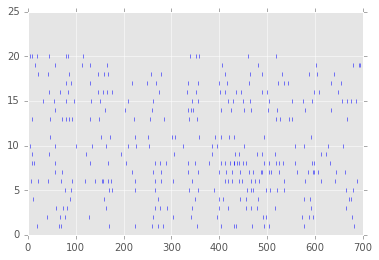

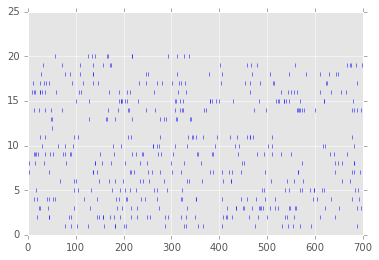

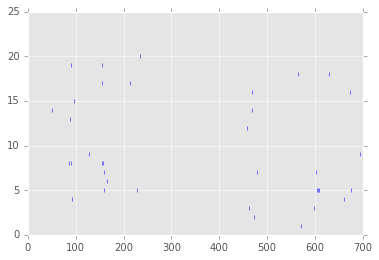

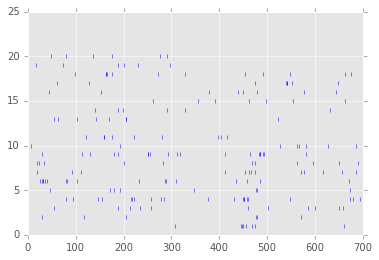

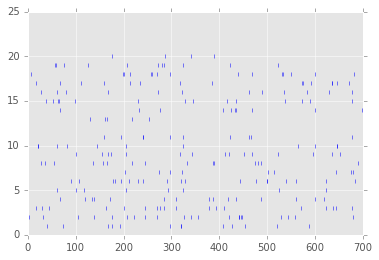

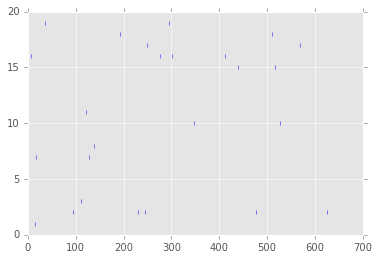

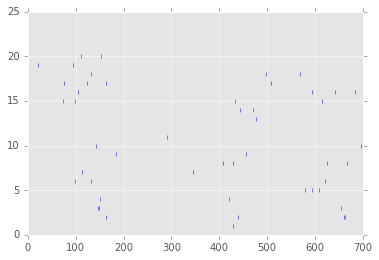

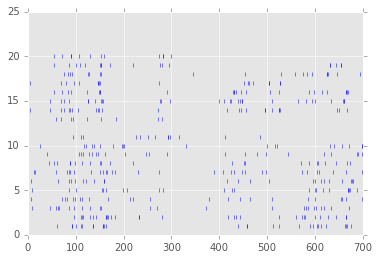

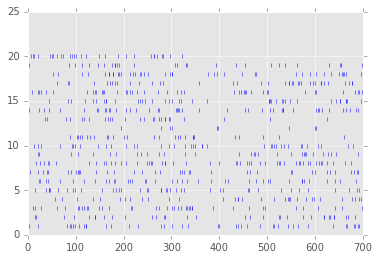

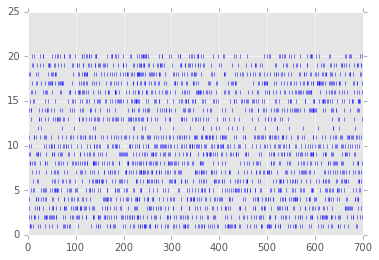

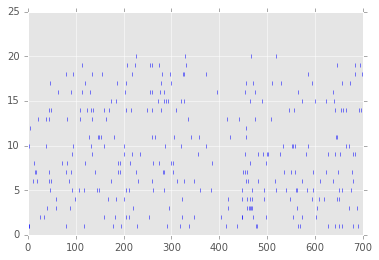

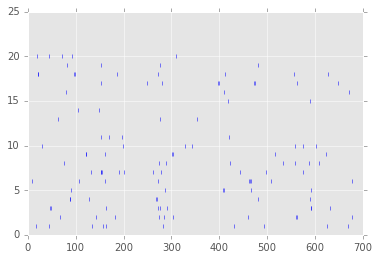

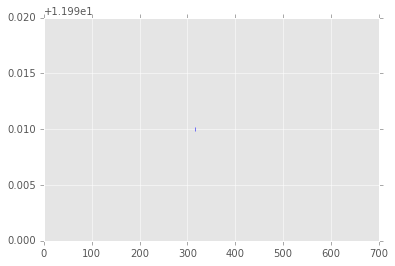

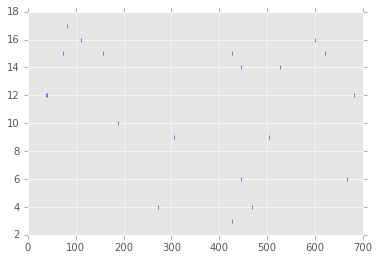

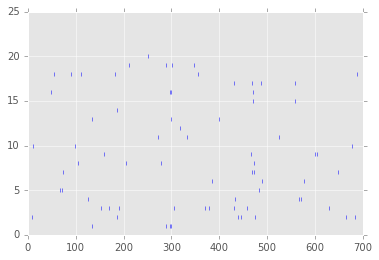

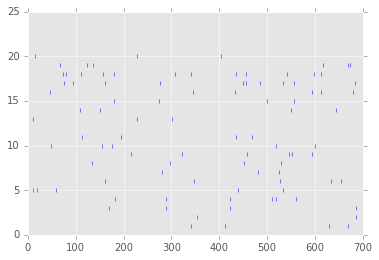

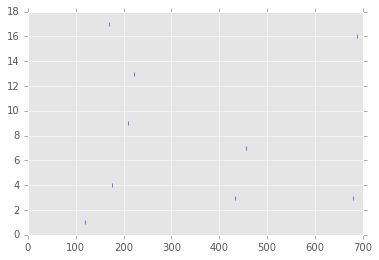

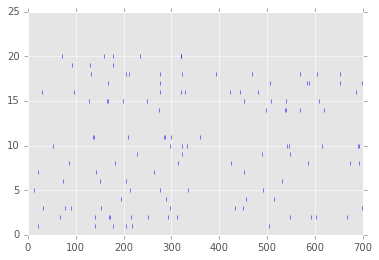

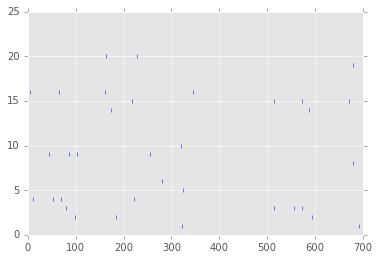

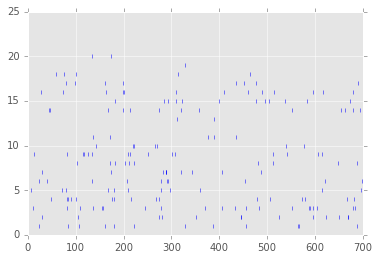

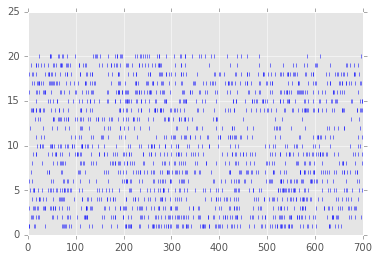

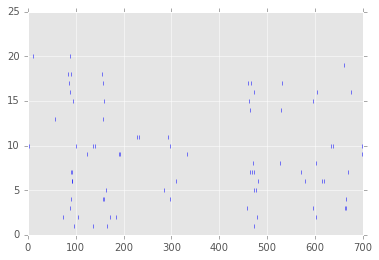

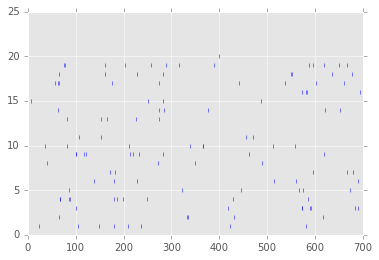

In [73]:
# get one of the units:
from basic_viewing.units import Unit
from basic_viewing.basic_plot import plot_raster, sparse_raster
from basic_viewing import basic_plot as bp
from phy_tools import kwik_functions as kwf

shank = 2
kwik_file_path = kwik_files[shank]
kwik_file = h5py.File(kwik_file_path, 'r')  

s_f = kwf.get_record_sampling_frequency(kwik_file)
# list all the sorted units
all_units = kwf.list_units(kwik_file, sorted=False)
# this returns a numpy recarray with cols:
# group: site group (electrode shank)
# clu: cluster number
# qlt: sorting quality: 1 is MUA, 2 is well isolated (by default, only these 2 qlt's are returned)
# For instance, see all the clusters that are either mua or good units.
print all_units['clu']

ifig = 0
def plot_one_raster(unit_clu):
    # instance a Unit object
    unit = Unit(unit_clu, h5=kwik_file)
    # get the spike times (in sample units)
    unit.get_time_stamps()
    # get the sampling rate of the recording
    s_f = unit.sampling_rate
    #get a raster for this unit around a window of [-2, 4] sec after each stimulus onset
    before_ms = 100
    after_ms = 600
    start_points = all_starts_samples - np.int(s_f * before_ms/1000.) #start_points has to be in sample units
    rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)
    # the raster is an n_trial * m array (where m can be sample or ms).
    # in each row, it contains the timestamps (in samples or ms) of spikes relative to the beginning of the trial
    # plot the raster
    b = np.outer((np.arange(rs.shape[0]) + 1), np.ones(rs.shape[1]))
    plt.figure(unit_clu)
    plt.scatter(rs, b, marker='|')
    plt.xlim(0, before_ms + after_ms)
    plt.show



for one_unit in all_units:
    one_unit_clu = one_unit['clu']
    plot_one_raster(one_unit_clu)
# plot the waveform underneath the raster
#span_before = np.zeros(np.int(before_ms/1000. * meta['stim']['sampling_rate']))
#span_before[:] = np.nan
#span_after = np.zeros(np.int(after_ms/1000. * meta['stim']['sampling_rate']) - waveform.size)
#waveform_plot = np.insert(waveform, 0, span_before)
#waveform_plot = np.insert(span_after, 0, waveform_plot)
#waveform_t_plot = np.arange(waveform_plot.size)*1000./meta['stim']['sampling_rate']
#plt.plot(waveform_t_plot, (waveform_plot/32768.-0.8)*10)


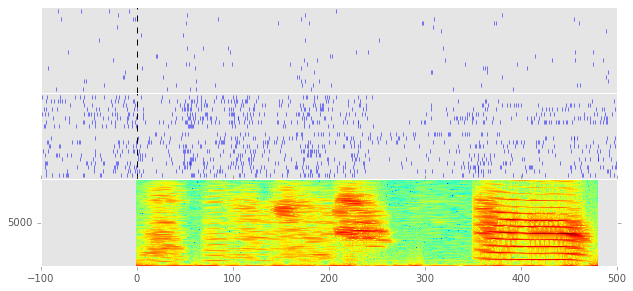

In [178]:
width=1
before_ms = 100
after_ms = 600
unit_clu = all_units[21]['clu']
unit = Unit(unit_clu, h5=kwik_file)
unit2 = Unit(all_units[43]['clu'], h5=kwik_file)
# get the spike times (in sample units)
#unit.get_time_stamps()
# get the sampling rate of the recording
s_f = unit.sampling_rate
#get a raster for this unit around a window of [-2, 4] sec after each stimulus onset
before_ms = 100
after_ms = 500
start_points = all_starts_samples - np.int(s_f * before_ms/1000.) #start_points has to be in sample units
rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)
rs2 = unit2.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)

fig = plt.figure()

ax1 = fig.add_axes([0,.3,width,0.3])
rast, ax1 = plot_raster(sparse_raster(rs), t0=before_ms, ax=ax1)
#rast, ax1 = plot_raster(sparse_raster(rs), t0=before_ms, bin_size=15, ax=ax1)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])

ax2 = fig.add_axes([0,.6,width,0.3])
rast, ax2 = plot_raster(sparse_raster(rs2), t0=before_ms, ax=ax2)
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])

ax0 = fig.add_axes([0,0,width,0.3])
spectr, ax0 = plot_spectrogram(motif, before_ms, after_ms, sound_sf, ax=ax0,
                               n_window = 512, n_overlap=512-1, scaling='spectrum')
ax0.yaxis.set_ticks([5000])

fig.set_size_inches(8, 4)
fig.set_dpi(1200)
fig.savefig(os.path.join(ss_sess_path, 'rasters.png'), orientation='portrait', format='png')


In [150]:
fig.savefig(os.path.join(ss_sess_path, 'rasters.png'), orientation='portrait', format='png')


(0, 6000)

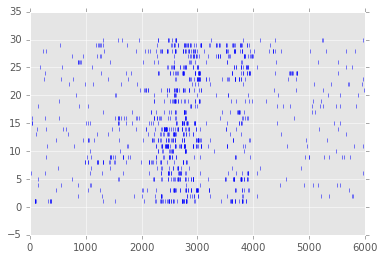

In [86]:
plt.scatter(rs, b, marker='|')
plt.xlim(0, before_ms + after_ms)

In [87]:
one_unit = all_units[11:12]

In [177]:
from basic_viewing.basic_plot import plot_raster, sparse_raster
import scipy.signal as sg
from scipy.signal import spectrogram

def plot_waveform(x, before_ms, after_ms, s_f, ax=None):
    span_before = np.zeros(np.int(before_ms/1000. * s_f))
    span_before[:] = np.nan
    span_after = np.zeros(np.int(after_ms/1000. * s_f) - x.size)
    waveform_plot = np.insert(x, 0, span_before)
    waveform_plot = np.insert(span_after, 0, waveform_plot)
    waveform_t_plot = np.arange(waveform_plot.size)*1000./s_f
    if ax is None:
        raster_fig = plt.figure()
        ax = raster_fig.add_axes([0, 0, 1, 1])
    ax.plot(waveform_plot)
    ax.set_xlim(0, waveform_plot.size)
    ax.plot((span_before.size, span_before.size), (np.min(waveform_plot), np.max(waveform_plot)), 'k--')
    return ax

def pad_input(sliding_func):
    def out_padded(*args, **kwargs):
        n_window = kwargs['nperseg']
        n_overlap = kwargs['noverlap']
        
        # pad the window so the output is the same size as the input
        assert(n_window%2 == 0)
        before_padding = n_window/2
        after_padding = n_window/2 -1 
        x = np.pad(args[0], (before_padding, after_padding), 'constant', constant_values = (0,0))
        # make the new input to the function
        args = (x,) + args[1:]
        return sliding_func(*args, **kwargs)
    
    return out_padded


fig = plt.figure()
#decorate spectrogram to pad so output and input sizes match
spectrogram = pad_input(spectrogram)
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 1024, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 7./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    
    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx))
    ax.set_xlim(-before_ms, after_ms)
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

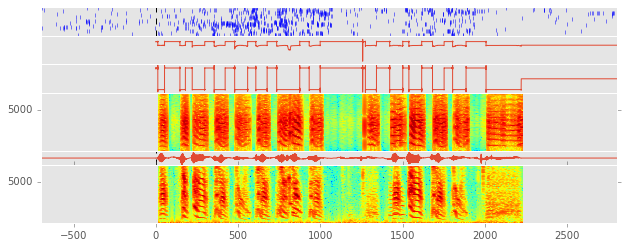

In [126]:
from basic_viewing.basic_plot import plot_raster, sparse_raster
import scipy.signal as sg
from scipy.signal import spectrogram

def plot_waveform(x, before_ms, after_ms, s_f, ax=None):
    span_before = np.zeros(np.int(before_ms/1000. * s_f))
    span_before[:] = np.nan
    span_after = np.zeros(np.int(after_ms/1000. * s_f) - x.size)
    waveform_plot = np.insert(x, 0, span_before)
    waveform_plot = np.insert(span_after, 0, waveform_plot)
    waveform_t_plot = np.arange(waveform_plot.size)*1000./s_f
    if ax is None:
        raster_fig = plt.figure()
        ax = raster_fig.add_axes([0, 0, 1, 1])
    ax.plot(waveform_plot)
    ax.set_xlim(0, waveform_plot.size)
    ax.plot((span_before.size, span_before.size), (np.min(waveform_plot), np.max(waveform_plot)), 'k--')
    return ax

def pad_input(sliding_func):
    def out_padded(*args, **kwargs):
        n_window = kwargs['nperseg']
        n_overlap = kwargs['noverlap']
        
        # pad the window so the output is the same size as the input
        assert(n_window%2 == 0)
        before_padding = n_window/2
        after_padding = n_window/2 -1 
        x = np.pad(args[0], (before_padding, after_padding), 'constant', constant_values = (0,0))
        # make the new input to the function
        args = (x,) + args[1:]
        return sliding_func(*args, **kwargs)
    
    return out_padded


fig = plt.figure()
#decorate spectrogram to pad so output and input sizes match
spectrogram = pad_input(spectrogram)
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 1024, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 7./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    
    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0*n_overlap/s_f)*1000.), f, np.log(Sxx))
    ax.set_xlim(-before_ms, after_ms)
    ax.set_ylim(0,7000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax
    
#spectr, ax3 = plot_spectrogram(waveform, before_ms, after_ms, meta['stim']['sampling_rate'], n_window = 1024, n_overlap=512, scaling='spectrum')
# plot the raster, the stimulus sonogram and the auxiliaries
before_ms = 700
after_ms = 2800

# The raster:
start_points = stim.start - np.int(s_f * before_ms/1000.) #start_points has to be in sample units
rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)


width=1
#ax1 = fig.add_axes([0,.5,2,0.25])
#rast, ax1 = plot_raster(sparse_raster(rs), t0=before_ms, ax=ax1)
#rast, ax1 = plot_raster(sparse_raster(rs), t0=before_ms, bin_size=15, ax=ax1)
ax1 = fig.add_axes([0,0.2,width,0.05])
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1 = plot_waveform(waveform, before_ms, after_ms, meta['stim']['sampling_rate'], ax=ax1)

ax0 = fig.add_axes([0,0,width,0.2])
spectr, ax0 = plot_spectrogram(waveform, before_ms, after_ms, meta['stim']['sampling_rate'], ax=ax0,
                               n_window = 1024, n_overlap=1024-128, scaling='spectrum')
ax0 = fig.add_axes([0,0,width,0.2])
ax0.yaxis.set_ticks([5000])

#synthetic
synth, meta_synth = stim.get_waveform(stream='synthesized')
ax2 = fig.add_axes([0,.25,width,0.2])
spectr, ax2 = plot_spectrogram(synth, before_ms, after_ms, meta['stim']['sampling_rate'], ax=ax2,
                               n_window = 1024, n_overlap=1024-128, scaling='spectrum')
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([5000])

w_axes = []
for i, stream in enumerate(['alpha', 'beta']):
    w_form, w_meta = stim.get_waveform(stream=stream)
    w_axes.append(fig.add_axes([0, 0.45 + i*0.1, width, 0.1]))
    this_ax = w_axes[i]
    this_ax = plot_waveform(w_form, before_ms, after_ms, meta['stim']['sampling_rate'], ax=this_ax)
    this_ax.xaxis.set_ticks([])
    this_ax.yaxis.set_ticks([])

# # plot all the rasters
#some_units = all_units[all_units.qlt == 2]
some_units = one_unit
rs_axes = []
for i_c, a_clu in enumerate(some_units['clu']):
    rs_axes.append(fig.add_axes([0, .65 + i_c*0.1, width, 0.1]))
    this_ax = rs_axes[i_c]
    
    unit = Unit(a_clu, h5=kwik_file)
    unit.get_time_stamps()
    rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)
    rast, this_ax = plot_raster(sparse_raster(rs), t0=before_ms, ax=this_ax, bin_size=0)
    
    this_ax.xaxis.set_ticks([])
    this_ax.yaxis.set_ticks([])

# fig.set_tight_layout(True)
fig.set_size_inches(8, 4)
fig.set_dpi(80)
# fig.show()

#fig.savefig(os.path.join(ss_file_folder, '{}_rasters.eps'.format(stim.name)), orientation='portrait', format='eps')
#fig.savefig(os.path.join(ss_file_folder, '{}_rasters.png'.format(stim.name)))

In [94]:
os.path.join(ss_file_folder, '{}_rasters.eps'.format(stim.name))

'/mnt/cube/earneodo/bci_zf/ss_data/z003/with_stims/S001_Pen03_Lft_AP500_ML500__Site01_Z2000__z003_cat_P03_S01_1_02/sound_001_40000_rasters.eps'

In [127]:
fig.set_tight_layout(True)
fig.set_size_inches(8, 4*(.65+all_units.shape[0]*0.1))
#fig.set_dpi(120)
#fig.show()

fig.savefig(os.path.join(ss_file_folder, '{}_rasters.eps'.format(stim.name)), orientation='portrait', format='eps',dpi=80)
fig.savefig(os.path.join(ss_file_folder, '{}_rasters.png'.format(stim.name)), orientation='portrait', format='png', dpi=80)

In [ ]:
# go through all the units and plot the rasters
# instance a Unit object
all_units['clu']
unit = Unit(one_unit_clu, h5=kwik_file)
# get the spike times (in sample units)
unit.get_time_stamps()
# get the sampling rate of the recording
s_f = unit.sampling_rate

In [ ]:
fig.savefig(os.path.join(ss_file_folder, '{}_rasters.png'.format(stim.name)))#rs.shape[1]

In [ ]:
# Get one of the arrays (for instance, parameters alpha and beta)
alpha, meta = stim.get_waveform(stream='alpha')
beta, meta = stim.get_waveform(stream='beta')
plt.plot(alpha)
plt.plot(beta)

In [7]:
# Get the syllables' segments for that stimulus:
[syllables_array, syllables_meta] = stim.get_syllables()
# This returns an array, and a dictionary (empty so far) with the metadata
# The table has three columns: Syllable identifiers (note that the syllables repeat across the realization), start, end
# (stamps are in sample units, with the same sampling rate as everything in the group for this stimulus)
print syllables_array

NameError: name 'stim' is not defined

In [162]:
import scipy.signal as sg

def pad_input(sliding_func):
    def out_padded(*args, **kwargs):
        n_window = kwargs['nperseg']
        n_overlap = kwargs['noverlap']
        
        # pad the window so the output is the same size as the input
        assert(n_window%2 == 0)
        before_padding = n_window/2
        after_padding = n_window/2 -1 
        x = np.pad(args[0], (before_padding, after_padding), 'constant', constant_values = (0,0))
        # make the new input to the function
        args = (x,) + args[1:]
        return sliding_func(*args, **kwargs)
    
    return out_padded

from scipy.signal import spectrogram

spectrogram = pad_input(spectrogram)

def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 1024, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 7./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    
    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh((t*1000. - n_window/(2.*s_f)*1000.), f, np.log(Sxx))
    ax.set_xlim(-before_ms, after_ms)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax
    
#spectr, ax3 = plot_spectrogram(waveform, before_ms, after_ms, meta['stim']['sampling_rate'], n_window = 1024, n_overlap=512, scaling='spectrum')

In [9]:
f, t, Sxx = spectrogram(waveform, meta['stim']['sampling_rate'], nperseg = 1024, noverlap=128, scaling='spectrum')

NameError: name 'waveform' is not defined

In [ ]:
t-512./40000.

In [10]:
# variables and parameters
y = window.data[0,:]
fs = window.sound.s_f
t = np.arange(0,y.shape[0], dtype=np.float)/fs

n_window = 1024
n_overlap = n_window-1
sigma = 7./1000.*fs

# pad the window so the output is the same size as the input
assert(n_window%2 == 0)
before_padding = n_window/2
after_padding = n_window/2 -1 
x = np.pad(y, (before_padding, after_padding), 'constant', constant_values = (0,0))

# Get the spectrogram of the padded segment
# overlap is n_window - 1, so that it slides across each time point
# window is gaussian so it ends up doing a sliding gabor transform, which is what I need to compute the fundamental
f, t, Sxx = sg.spectrogram(x, fs, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')

ax1 = plt.subplot(311)
plt.plot(t, y)
plt.subplot(212, sharex=ax1)
plt.pcolormesh(t, f, np.log(Sxx))
plt.ylim(0, 7000)

plt.show()


NameError: name 'window' is not defined